# 第6章: 機械学習
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形
[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)をダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
ls NewsAggregatorDataset/

2pageSessions.csv  newsCorpora.csv    readme.txt


id title url publisher category story hostname timestamp

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('./NewsAggregatorDataset/newsCorpora.csv', header=None, sep='\t', names=['ID', 'TITLE', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df_2 = df[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])]

In [4]:
len(df_2)

13340

In [5]:
# 分割
train, val_tra = train_test_split(df_2, test_size=0.2, shuffle=True, random_state=111, stratify=df_2['CATEGORY'])
valid, test = train_test_split(val_tra, test_size=0.5, shuffle=True, random_state=111, stratify=val_tra['CATEGORY'])

In [6]:
# 保存
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

In [7]:
# 事例数
print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

学習データ
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
検証データ
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
評価データ
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


In [8]:
df_2['CATEGORY'].value_counts()

b    5627
e    5279
t    1524
m     910
Name: CATEGORY, dtype: int64

## 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train['TITLE'])
X_valid = vectorizer.transform(valid['TITLE'])
X_test = vectorizer.transform(test['TITLE'])

In [10]:
np.savetxt('./train.feature.txt', X_train.toarray(), fmt='%d')
np.savetxt('./valid.feature.txt', X_valid.toarray(), fmt='%d')
np.savetxt('./test.feature.txt', X_test.toarray(), fmt='%d')

## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
logi = LogisticRegression(random_state=0, max_iter=10000)
logi.fit(X_train, train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=0)

## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [17]:
def pred_score(x):
    score = np.max(logi.predict_proba(x), axis=1)
    pred = logi.predict(x)
    return pred, score

In [18]:
pred_tra, score_tra = pred_score(X_train)
pred_tes, score_tes = pred_score(X_test)

In [20]:
print(pred_tra)
print(score_tra)
print(pred_tes)
print(score_tes)

['e' 'b' 'e' ... 'b' 'e' 'b']
[0.99668918 0.62613973 0.99901699 ... 0.99196286 0.95074975 0.97821534]
['b' 'b' 'b' ... 'b' 'e' 'e']
[0.99447863 0.9925174  0.9450859  ... 0.41726868 0.99196724 0.68815939]


## 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [23]:
from sklearn.metrics import accuracy_score

In [25]:
tra_accuracy = accuracy_score(train['CATEGORY'], pred_tra)

In [26]:
tes_accuracy = accuracy_score(test['CATEGORY'], pred_tes)

In [27]:
print(f'学習データ 正解率：{tra_accuracy:.3f}')
print(f'評価データ 正解率：{tes_accuracy:.3f}')

学習データ 正解率：0.993
評価データ 正解率：0.887


## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

### 混同行列
機械学習の評価指標

![cm.png](cm.png)

正解率：(TP+TN) / (TP+FN+FP+TN)

検出率：TP / (TP+FN)

精度：TP / (TP+FP)

誤検出率：FP / (FP+TN)

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

[[4483    4    1   14]
 [  11 4212    0    0]
 [  11    3  711    3]
 [  26    4    0 1189]]


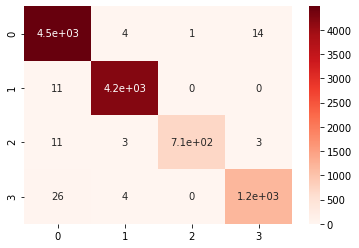

In [29]:
# trainデータ
train_cm = confusion_matrix(train['CATEGORY'], pred_tra)
print(train_cm)
sns.heatmap(train_cm, annot=True, cmap='Reds')
plt.show()

[[517  27   5  14]
 [ 14 506   3   5]
 [ 17  22  49   3]
 [ 23  17   1 111]]


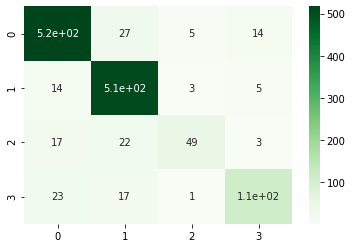

In [31]:
# testデータ
test_cm = confusion_matrix(test['CATEGORY'], pred_tes)
print(test_cm)
sns.heatmap(test_cm, annot=True, cmap='Greens')
plt.show()